# Generating a map of *Eucalyptus* and *Pinus* planted forests in Brazil

## This code gets data from the Brazilian Institute of Geography and Statistics (IBGE), regarding state borders and the distribution of planted forest for wood and cellulose in the country. 

### First step: get Brazilian borders from IBGE API

Import libraries needed for connecting to IBGE and to proceess georreferenced data.

In [1]:
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

**Note**: While building this code, I've found another option to get Brazilian border, via the `geobr` library, from the Brazilian Institute for Applied Economic Research (IPEA). In here, I will keep using the IBGE API connection, but it is good to keep the `geobr` option in mind for similar applications.  

Get Brazilian borders via IBGE API. The query url has been generated manually by the query builder available at IBGE's website https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-bq

It sets the API to deliver data in topojson format, at maximum available quality

In [2]:
ibge_api_url = 'https://servicodados.ibge.gov.br/api/v3/malhas/paises/BR?formato=application/json&qualidade=maxima'
r = requests.get(ibge_api_url) 
r.status_code # Check if connection was successful

200

Save json data, open it with `geopandas`

<AxesSubplot:title={'center':'Yearly mean of daily GHI totals'}>

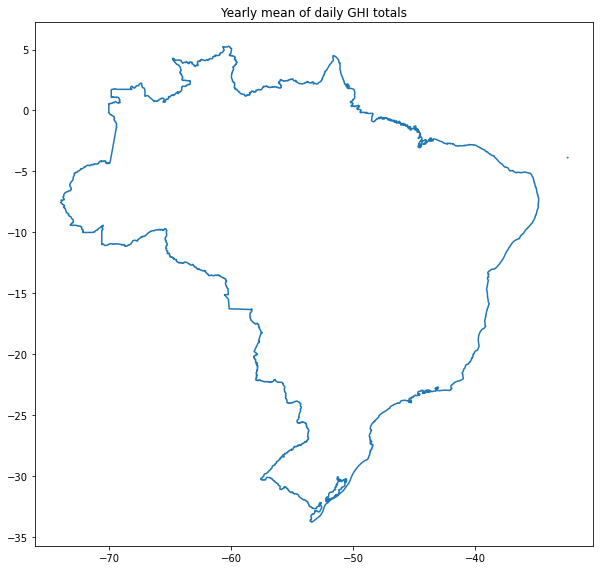

In [3]:
%%capture --no-display 
# geopandas would show some warnings here, turned them off

# Save .json file
json_data = json.loads(r.content)
filename = "br_border.json"

with open(filename, 'w') as json_file:
    json.dump(json_data, json_file)   
    json_file.close()    

# Open file with geopandas
br_borders = gpd.GeoDataFrame.from_file(filename)

# Plot borders to check if everything is OK
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title('Yearly mean of daily GHI totals')
br_borders.boundary.plot(ax=ax)

### Now that country borders are available, time to get vegetation cover data.

This data was manually downloaded from the IBGE's BDIA application (https://bdiaweb.ibge.gov.br/#/consulta/vegetacao), as it was not available via API.

Let's open it with `geopandas` and see what's inside

In [ ]:
veg_cover_data = gpd.read_file('vege_area/vege_area.shp')
veg_cover_data.head()

For a complete description of the contents in the file, check https://bdiaweb.ibge.gov.br/#/sobre/vegetacao (I'm afraid it's only available in Portuguese...)

Of interest to us is the **leg_uantr** column, which contains the register of man-made vegetal land cover, i.e., planted areas. We are interested in areas registered by the strings `'Re'` (eucalyptus reforestation areas) and `'Rp'` (pinus reforestation areas)

In [ ]:
idx = veg_cover_data.leg_uantr.isin(['Re','Rp'])
planted_forests_data = veg_cover_data[idx.values]
planted_forests_data.head()

Now we can plot both the country borders and the planted forests within it. Country borders were previously stored in a json file generated by the notebook available [here](https://github.com/L-Lemos/phd_thesis/blob/main/BR_Maps/Solar_Atlas_2017_GHI/Brazil_Solar_Irradiation_Map.ipynb)

In [ ]:
%%capture --no-display 
# geopandas would show some warnings here, turned them off

# Plot final map
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.title('Planted forests of Eucalyptus and Pinus in Brazil')
br_borders.boundary.plot(ax=ax, color='black')

# Set proper labels areas of eucalyptus and of pinus
planted_forests_data.insert(len(planted_forests_data.columns),'Label',' ') # Insert new column
planted_forests_data.loc[planted_forests_data.leg_uantr == 'Re','Label'] = 'Eucaliptus' # Assign labels to eucalyptus areas
planted_forests_data.loc[planted_forests_data.leg_uantr == 'Rp','Label'] = 'Pinus' # Assign labels to pinus areas

# Plot planted areas
planted_forests_data.plot(column = 'Label', ax=ax, legend=True, 
                                        cmap = matplotlib.colors.ListedColormap(['darkgreen','brown']))

plt.savefig('BR_planted_forests_map.png')